In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import spearmanr

In [29]:
# 31016: Glasser 
# 31018: Schaefer7ns 100p to 1000p 
# 31019: Tian Subcortex S1 to S4 3T 
# 31015: aparc 
# 31014: aparc a2009s
selected_atlas_combinations=(
	# DK atlas + S1 subcortical atlas
	"aparc,Tian_Subcortex_S1_3T"
	# Destrieux atlas + S1 subcortical atlas
	"aparc.a2009s,Tian_Subcortex_S1_3T"
	# Glasser atlas + S1 subcortical atlas
	"Glasser,Tian_Subcortex_S1_3T"
	# Glasser atlas + S4 subcortical atlas
	"Glasser,Tian_Subcortex_S4_3T"
	# Schaeffer200 atlas + S1 subcortical atlas
	"Schaefer7n200p,Tian_Subcortex_S1_3T"
	# Schaeffer500 atlas + S4 subcortical atlas
	"Schaefer7n500p,Tian_Subcortex_S4_3T"
	# Schaeffer1000 atlas + S4 subcortical atlas
	"Schaefer7n1000p,Tian_Subcortex_S4_3T"
)

In [30]:
#chosen_atlas_combination=["Schaefer7n500p","Tian_Subcortex_S4_3T"]
#try before get any subcortex data
#selected_atlas_combinations=["Schaefer7n500p","Tian_Subcortex_S4_3T"]
selected_atlas_combinations=["Schaefer7n500p"]
user_dir = '/Users/xiaoqianxiao'
projectName = 'UKB'
data_dir = os.path.join(user_dir, projectName, "data")
derivatives_dir = os.path.join(data_dir, 'derivatives')
behav_file_path = os.path.join(data_dir, 'anxiety_fMRI_participants.csv')

In [31]:
participants_df = pd.read_csv(behav_file_path)
subject_IDs = participants_df['eid']

In [50]:
GAD_score_file_path = os.path.join(data_dir, 'gad_score.csv')
df_GAD_score = pd.read_csv(GAD_score_file_path)
df_filtered_all = df_GAD_score[df_GAD_score['eid'].isin(subject_id_list_filtered)]
df_filtered = df_filtered_all[df_filtered_all['GAD7_score'] > 0].copy()
scaler = StandardScaler()
df_filtered['GAD7_score_standardized'] = scaler.fit_transform(df_filtered[['GAD7_score']])

Index(['filepath', 'param', 'eid', 'field_id', 'ins'], dtype='object')

In [32]:
#for each subject:
#subject_ID = subject_IDs[3]
session_ID = 2
#load timeseries
#session_ID in range(2,4):
# Initialize lists to hold the data
X = []  # To hold the time series data
subject_id_list_ori = []  # To hold the subject IDs

# Loop through the list of subject IDs
for subject_ID_ori in subject_IDs:
    df_sub_session = pd.DataFrame()  # Initialize an empty DataFrame for each subject
    c = 0  # Counter to track if at least one data file is found

    # Loop through the selected atlas combinations
    for i in selected_atlas_combinations:
        data_file_name = f"sub-{subject_ID_ori}_ses-{session_ID}_task-rest_space-{i}.csv.gz"
        data_file_path = os.path.join(derivatives_dir, 'timeseries', data_file_name)
        
        # Check if the file exists
        if os.path.exists(data_file_path):
            c += 1  # Increment the counter if file is found
            
            # Load the data file and concatenate to the subject's data
            df = pd.read_csv(data_file_path, compression='gzip', index_col=0, header=0)
            df_sub_session = pd.concat([df_sub_session, df], axis=1)  # Concatenate data across columns
    
    # If at least one file was found for the current subject
    if c > 0:
        # Transpose the DataFrame (convert columns to rows)
        transposed_df = df_sub_session.transpose()

        # Convert the transposed DataFrame to a numpy array (time series)
        time_series = transposed_df.to_numpy()

        # Append the time series data and subject ID to the lists
        X.append(time_series)
        subject_id_list_ori.append(subject_ID_ori)

EmptyDataError: No columns to parse from file

In [33]:
X_cleaned = []
# Step 1: Handle NaN values by filling them with the mean of each feature
for i, data in enumerate(X):
    # Skip empty arrays
    if data.size == 0:
        print(f"Subject {i + 1} has an empty array. Skipping.")
        continue

    if np.all(np.isnan(data)):  # Check if all values are NaN
        print(f"Subject {i + 1} has all NaN values. Filling with zeros.")
        data_filled = np.zeros_like(data)
        X_cleaned.append(data_filled)
        continue

    # Fill NaNs column-wise with the mean of each feature
    data_filled = np.copy(data)  # Make a copy of the data to modify
    for j in range(data.shape[1]):  # Iterate over each feature (column)
        if np.isnan(data[:, j]).any():  # If the column contains NaNs
            if np.all(np.isnan(data[:, j])):  # If all values in the column are NaN
                print(f"Column {j} in Subject {i + 1} has all NaN values. Filling with zeros.")
                data_filled[:, j] = np.zeros(data.shape[0])  # Fill the entire column with zeros
            else:
                feature_mean = np.nanmean(data[:, j])  # Compute mean ignoring NaNs
                data_filled[:, j] = np.nan_to_num(data[:, j], nan=feature_mean)  # Replace NaNs with the mean of the column

    X_cleaned.append(data_filled)

# Step 2: Remove constant features
X_filtered = []
subject_id_list_filtered = []
for i, data in enumerate(X_cleaned):
    subject_ID = subject_id_list_ori[i]
    non_constant_features = data[:, data.std(axis=0) != 0]
    if non_constant_features.shape[1] < data.shape[1]:
        print(f"Removed constant features for Subject {i + 1}.")
    if non_constant_features.size == data.size: #only append if non constant features
		#non_constant_features.size > 0:  # Only append if there are remaining features
        X_filtered.append(non_constant_features)
        subject_id_list_filtered.append(subject_ID)

# Step 3: Final check for any remaining NaNs
X_final = []
for i, data in enumerate(X_filtered):
    if np.isnan(data).any():
        print(f"Subject {i + 1} still has NaN values after filtering. Filling remaining NaNs with zeros.")
        data_filled = np.nan_to_num(data, nan=0)  # Fill any remaining NaNs with zeros
        X_final.append(data_filled)
    else:
        X_final.append(data)

# Ensure consistency in the number of features
if not all(data.shape[1] == X_final[0].shape[1] for data in X_final):
    raise ValueError("All subjects must have the same number of features before standardization.")

# Step 3: Standardize data
X_standardized = [StandardScaler().fit_transform(data) for data in X_final]

Column 491 in Subject 20 has all NaN values. Filling with zeros.
Column 446 in Subject 141 has all NaN values. Filling with zeros.
Column 448 in Subject 220 has all NaN values. Filling with zeros.
Column 180 in Subject 296 has all NaN values. Filling with zeros.
Column 448 in Subject 296 has all NaN values. Filling with zeros.
Column 448 in Subject 312 has all NaN values. Filling with zeros.
Column 180 in Subject 492 has all NaN values. Filling with zeros.
Column 446 in Subject 492 has all NaN values. Filling with zeros.
Column 448 in Subject 492 has all NaN values. Filling with zeros.
Column 448 in Subject 513 has all NaN values. Filling with zeros.
Column 447 in Subject 652 has all NaN values. Filling with zeros.
Column 448 in Subject 652 has all NaN values. Filling with zeros.
Removed constant features for Subject 20.
Removed constant features for Subject 35.
Removed constant features for Subject 54.
Removed constant features for Subject 141.
Removed constant features for Subject 19

In [34]:
# Initialize ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
# Fit and transform to compute connectivity matrices
connectivity_matrices = correlation_measure.fit_transform(X_standardized)
# Use numpy to get the upper triangle of each connectivity matrix
num_subjects = connectivity_matrices.shape[0]
num_nodes = connectivity_matrices.shape[1]

# Get upper triangle indices (excluding diagonal)
upper_tri_indices = np.triu_indices(num_nodes, k=1)

# Flatten and store the upper triangle values in the desired shape
upper_triangle_flattened = np.empty((num_subjects, len(upper_tri_indices[0])))

# Extract upper triangle values for each subject
for i in range(num_subjects):
    upper_triangle_flattened[i] = connectivity_matrices[i][upper_tri_indices]

# Check the shape of the result
print(upper_triangle_flattened.shape) 

(646, 124750)


In [47]:
#Feature selection
GAD_score_file_path = os.path.join(data_dir, 'gad_score.csv')
df_GAD_score = pd.read_csv(GAD_score_file_path)
df_filtered_all = df_GAD_score[df_GAD_score['eid'].isin(subject_id_list_filtered)]
df_filtered = df_filtered_all[df_filtered_all['GAD7_score'] > 0].copy()
scaler = StandardScaler()
df_filtered['GAD7_score_standardized'] = scaler.fit_transform(df_filtered[['GAD7_score']])

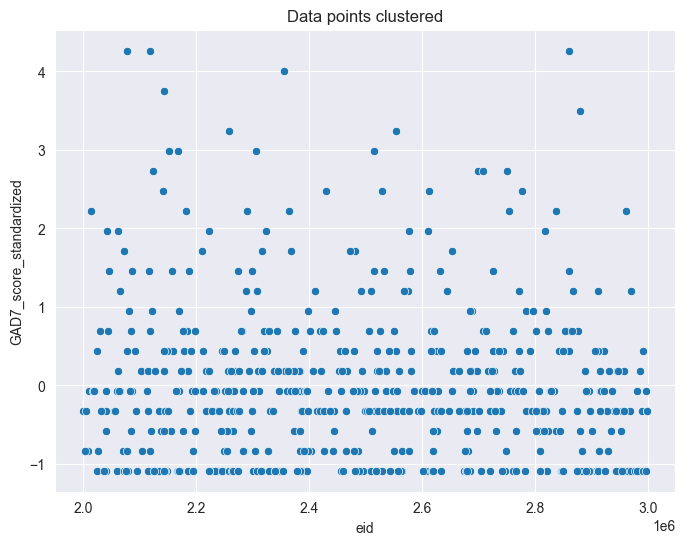

In [48]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_filtered, x='eid', y='GAD7_score_standardized')

# Add labels and title
plt.title('Data points clustered')
#plt.xlabel('Sepal Length (cm)')
#plt.ylabel('Sepal Width (cm)')

# Show the plot
plt.show()

In [49]:
# Step 2: Spearman's rank correlation for each feature against each symptom
# Store p-values and correlation coefficients
n_connectivity_features = upper_triangle_flattened.shape[1]
n_symptoms = df_filtered.shape[1] - 1
p_values = np.zeros((n_connectivity_features, n_symptoms))
correlation_coeffs = np.zeros((n_connectivity_features, n_symptoms))

for i in range(n_connectivity_features):
    for j in range(n_symptoms):
        #rho, p_val = spearmanr(upper_triangle_flattened[:, i], GAD_score[:, j])
        rho, p_val = spearmanr(upper_triangle_flattened[:, i], GAD_score_standardized)
        correlation_coeffs[i, j] = rho
        p_values[i, j] = p_val

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 646 and the array at index 1 has size 641

In [ ]:
# Step 3: Select connectivity features with significant correlations (p < 0.005)
# Apply the significance threshold (you can also apply FDR correction if needed)
threshold = 0.005
significant_features = np.where(p_values < threshold)[0]
filtered_connectivity_features = upper_triangle_flattened[:, significant_features]

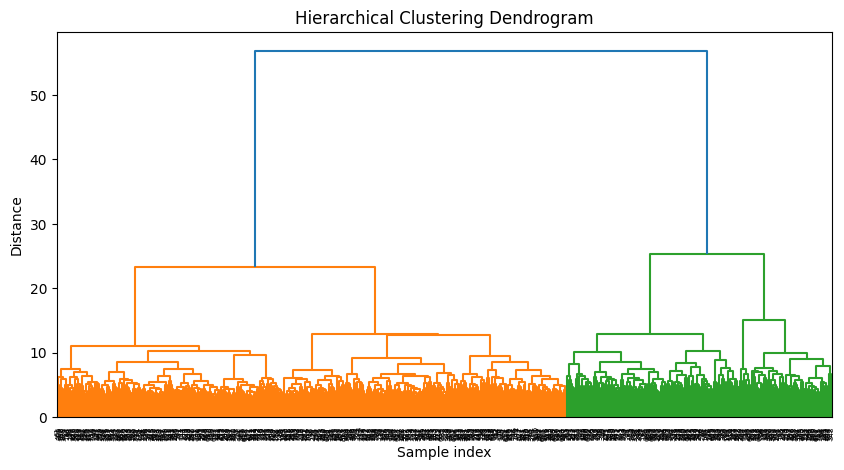

In [383]:
#Method 1: using all significant features
Z = linkage(filtered_connectivity_features, method='ward') 
# Step 2: Plot the dendrogram to visualize the hierarchy
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

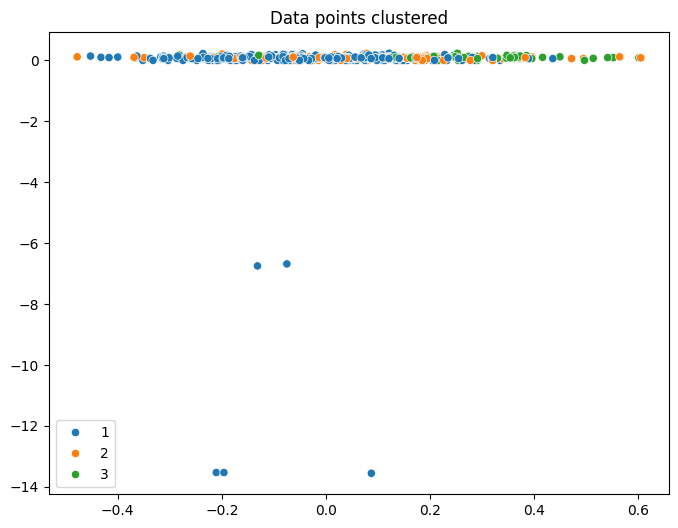

In [406]:
most_significant_features = np.where(p_values == p_values.max())[0]
filtered_most_significant_features = upper_triangle_flattened[:, most_significant_features]
x = filtered_most_significant_features[:,0]  # Select the first dimension of x-axis data
y = GAD_score_standardized  # Select the first dimension of y-axis data
# Step 3: Cutting the dendrogram to form clusters
# Choose a threshold distance at which to cut the dendrogram (you can adjust this value)
max_d = 25  # Adjust based on dendrogram
clusters = fcluster(Z, max_d, criterion='distance')
cluster_categories = pd.Categorical(clusters)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=cluster_categories)

# Add labels and title
plt.title('Data points clustered')
#plt.xlabel('Sepal Length (cm)')
#plt.ylabel('Sepal Width (cm)')

# Show the plot
plt.show()

In [403]:
cluster_categories

[2, 3, 2, 3, 2, ..., 2, 1, 3, 4, 2]
Length: 646
Categories (4, int32): [1, 2, 3, 4]

In [379]:
# Step 4: Apply(CCA)
# Define the CCA model with the number of components (can be less than min(n_connectivity_features, n_symptoms))
n_components = min(len(significant_features), n_symptoms)
cca = CCA(n_components=n_components)

# Fit the CCA model
cca.fit(filtered_connectivity_features, GAD_score_standardized)

# Transform the features and symptoms into their canonical representations
connectivity_canonical, symptoms_canonical = cca.transform(filtered_connectivity_features, GAD_score_standardized)

# Step 5: Output the low-dimensional representations
print("Canonical representations of connectivity features:")
print(connectivity_canonical)
print("\nCanonical representations of symptoms:")
print(symptoms_canonical)

Canonical representations of connectivity features:
[[ 2.09914684e-02]
 [ 9.49401748e-02]
 [-4.70672045e-02]
 [ 1.11164396e-02]
 [ 4.67402079e-02]
 [-1.41930048e-02]
 [-2.56621966e-03]
 [ 4.88091161e-02]
 [ 2.87577512e-02]
 [ 5.25776693e-03]
 [ 1.49771945e-01]
 [ 1.86564883e-02]
 [ 7.38795173e-02]
 [ 5.97982513e-03]
 [-1.93207191e-02]
 [ 4.20807667e-05]
 [ 6.38099292e-02]
 [-2.87418531e-02]
 [ 5.87538333e-02]
 [-3.88536076e-02]
 [-8.92923786e-03]
 [ 4.16230668e-03]
 [ 3.37571126e-02]
 [-5.79164028e-02]
 [ 1.20398841e-02]
 [ 8.39124794e-02]
 [-1.26634988e-03]
 [ 9.66219196e-03]
 [ 4.34475500e-02]
 [ 1.07428159e-01]
 [-8.82017324e-03]
 [ 3.33420430e-03]
 [ 1.00042956e-01]
 [-1.47424530e-02]
 [ 4.35739967e-04]
 [ 6.22352761e-02]
 [ 3.12386136e-02]
 [-9.44587097e-03]
 [ 1.31078377e-01]
 [ 5.56418564e-02]
 [-2.37421789e-02]
 [-2.53937340e-02]
 [ 5.11241702e-02]
 [ 4.46295973e-02]
 [-3.69801113e-02]
 [-4.84273682e-02]
 [ 6.94909046e-03]
 [-2.14264519e-02]
 [ 1.88089407e-02]
 [-4.58983506e-02

In [365]:
connectivity_canonical.shape

(646, 1)

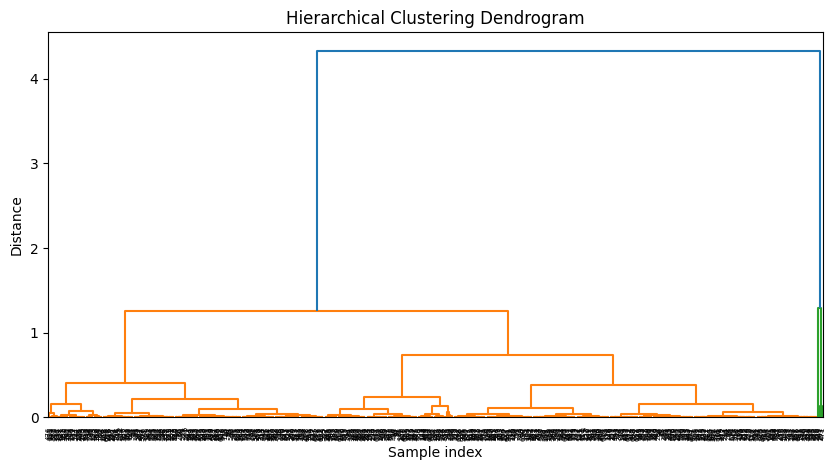

In [380]:
# Step 1: Perform hierarchical clustering using linkage
#Z = linkage(upper_triangle_flattened, method='ward')  # 'ward' minimizes the total within-cluster variance
Z = linkage(connectivity_canonical, method='ward') 
# Step 2: Plot the dendrogram to visualize the hierarchy
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

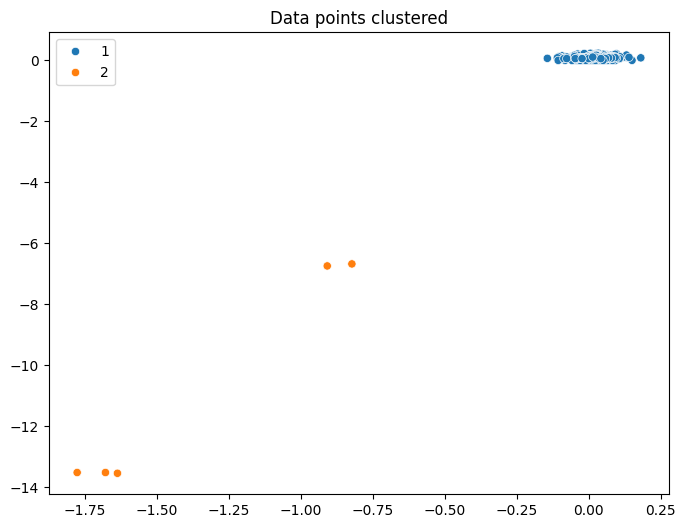

In [381]:
x = connectivity_canonical[:, 0]  # Select the first dimension of x-axis data
y = symptoms_canonical[:, 0]  # Select the first dimension of y-axis data
# Step 3: Cutting the dendrogram to form clusters
# Choose a threshold distance at which to cut the dendrogram (you can adjust this value)
max_d = 2  # Adjust based on dendrogram
clusters = fcluster(Z, max_d, criterion='distance')
cluster_categories = pd.Categorical(clusters)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=cluster_categories)

# Add labels and title
plt.title('Data points clustered')
#plt.xlabel('Sepal Length (cm)')
#plt.ylabel('Sepal Width (cm)')

# Show the plot
plt.show()

In [376]:
import plotly.express as px
# Create an interactive 3D scatter plot using Plotly
fig = px.scatter(x=x,
                y=y,
                color=cluster_categories,
                title='Scatter Plot of Clusters'
                ) 

# Show the plot
fig.show()

In [179]:
from sklearn.tree import DecisionTreeClassifier
# Cluster labels from KMeans
labels = clusters
# Train a decision tree classifier to predict cluster labels
tree = DecisionTreeClassifier(random_state=42)
tree.fit(upper_triangle_flattened, clusters)

DecisionTreeClassifier(random_state=42)

In [272]:
# Get feature importance
feature_importance = tree.feature_importances_

# Create a DataFrame for easier interpretation
df_feature_importance = pd.DataFrame({
    #'Feature': [f'Feature {i }' for i in range(upper_triangle_flattened.shape[1])],
    'Feature_id': range(upper_triangle_flattened.shape[1]),
    'Importance': feature_importance
})
df_feature_importance_sorted = df_feature_importance.sort_values(by='Importance', ascending=False)
print("Feature importance based on decision tree:")
print(df_feature_importance_sorted)

Feature importance based on decision tree:
        Feature_id  Importance
82343        82343    0.147369
2032          2032    0.097307
42726        42726    0.063792
102548      102548    0.057235
15266        15266    0.042124
...            ...         ...
41591        41591    0.000000
41590        41590    0.000000
41589        41589    0.000000
41588        41588    0.000000
124749      124749    0.000000

[124750 rows x 2 columns]


In [291]:
label_dir = '/Users/xiaoqianxiao/tool/keep_for_future_usage/UKB-connectomics/data/templates/atlases/labels'
label_filenames = [f'{atlas_combination}.label_List.txt' for atlas_combination in selected_atlas_combinations]
df_labels_all = pd.DataFrame()
for i in range(len(selected_atlas_combinations)):
    df_label = pd.DataFrame()
    label_file_path = os.path.join(label_dir, label_filenames[i])
    df = pd.read_csv(label_file_path, header=None, sep='\t', engine='python')
    odd_rows = df.iloc[0::2].reset_index(drop=True)  # Rows at even indices (0-based)
    even_rows = df.iloc[1::2].reset_index(drop=True)  # Rows at odd indices (0-based)
    combined_df = pd.DataFrame({
    'Odd Rows': odd_rows[0],
    'Even Rows': even_rows[0]
    })
    combined_df[['Column1', 'Column2']] = combined_df['Even Rows'].str.split(' ', n=1, expand=True)
    df_label[['ROI_id','ROI_name','ROI_coordinate']] = combined_df[['Column1', 'Odd Rows','Column2']]
    df_labels_all = pd.concat([df_labels_all, df_label], axis=1)
df_labels = pd.DataFrame()
row_indices = upper_tri_indices[0]
col_indices = upper_tri_indices[1]
ROI1 = df_labels_all.loc[row_indices][['ROI_id','ROI_name']]
ROI2 = df_labels_all.loc[col_indices][['ROI_id','ROI_name']]
df_labels = pd.DataFrame({ 'Feature_id': df_feature_importance['Feature_id'].values, 'ROI1_id': ROI1['ROI_id'].values, 'ROI2_id': ROI2['ROI_id'].values, 'ROI_1': ROI1['ROI_name'].values, 'ROI_2': ROI2['ROI_name'].values,'Importance': df_feature_importance['Importance'].values})

In [306]:
df_labels_sorted = df_labels.sort_values(by='Importance', ascending=False)

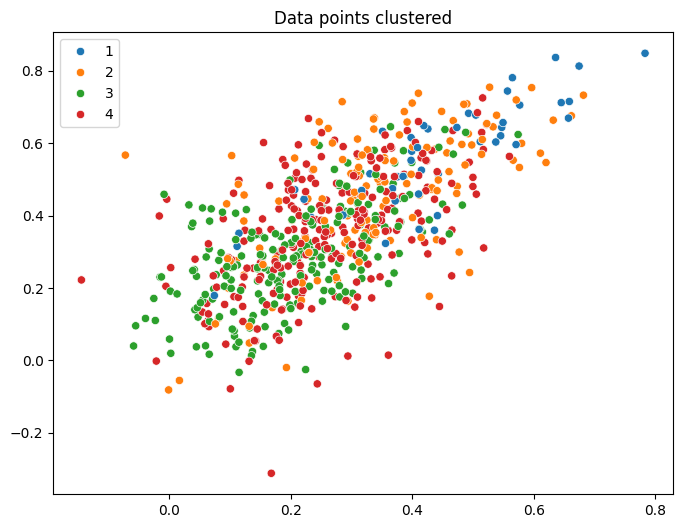

In [307]:
# Step 3: Cutting the dendrogram to form clusters
# Choose a threshold distance at which to cut the dendrogram (you can adjust this value)
max_d = 281  # Adjust based on dendrogram
clusters = fcluster(Z, max_d, criterion='distance')
cluster_categories = pd.Categorical(clusters)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=upper_triangle_flattened[:, df_labels_sorted['Feature_id'][0]], y=upper_triangle_flattened[:, df_labels_sorted['Feature_id'][1]], hue=cluster_categories)

# Add labels and title
plt.title('Data points clustered')
#plt.xlabel('Sepal Length (cm)')
#plt.ylabel('Sepal Width (cm)')

# Show the plot
plt.show()

In [309]:
import plotly.express as px

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(x=upper_triangle_flattened[:, df_labels_sorted['Feature_id'][0]],
                    y=upper_triangle_flattened[:, df_labels_sorted['Feature_id'][1]],
                    z=upper_triangle_flattened[:, df_labels_sorted['Feature_id'][2]],
                    color=cluster_categories,
                    title='Scatter Plot of Clusters',
                    labels={'Feature_0': 'Feature 0', 
                            'Feature_1': 'Feature 1', 
                            'Feature_2': 'Feature 2'}
                    ) 

# Show the plot
fig.show()